
[Run] /root/autodl-tmp/AceMath


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

[Placement] AceMath -> cuda:0, dtype=torch.bfloat16; CUDA_VISIBLE_DEVICES=0
[Output] All files for this model will be saved to: AceMath
[Seed 42] Split: Train=800, Val=100, Test=100 / Total=1000
[Introspect] layers=28, hidden_size=3584


Caching-train:   0%|          | 0/7 [00:00<?, ?it/s]

Caching-val:   0%|          | 0/1 [00:00<?, ?it/s]

Caching-test:   0%|          | 0/1 [00:00<?, ?it/s]

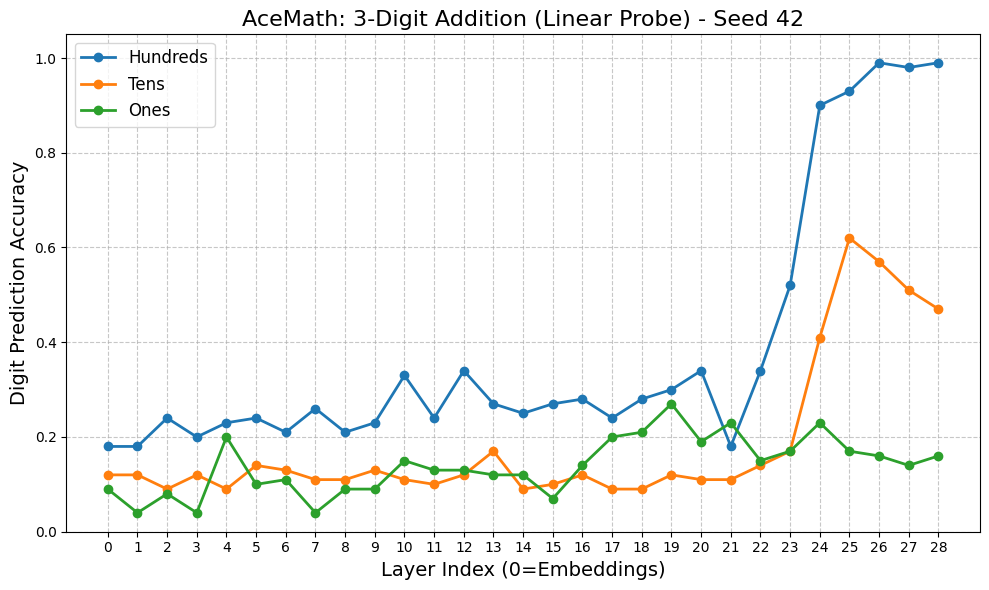

[Seed 43] Split: Train=800, Val=100, Test=100 / Total=1000
[Introspect] layers=28, hidden_size=3584


Caching-train:   0%|          | 0/7 [00:00<?, ?it/s]

Caching-val:   0%|          | 0/1 [00:00<?, ?it/s]

Caching-test:   0%|          | 0/1 [00:00<?, ?it/s]

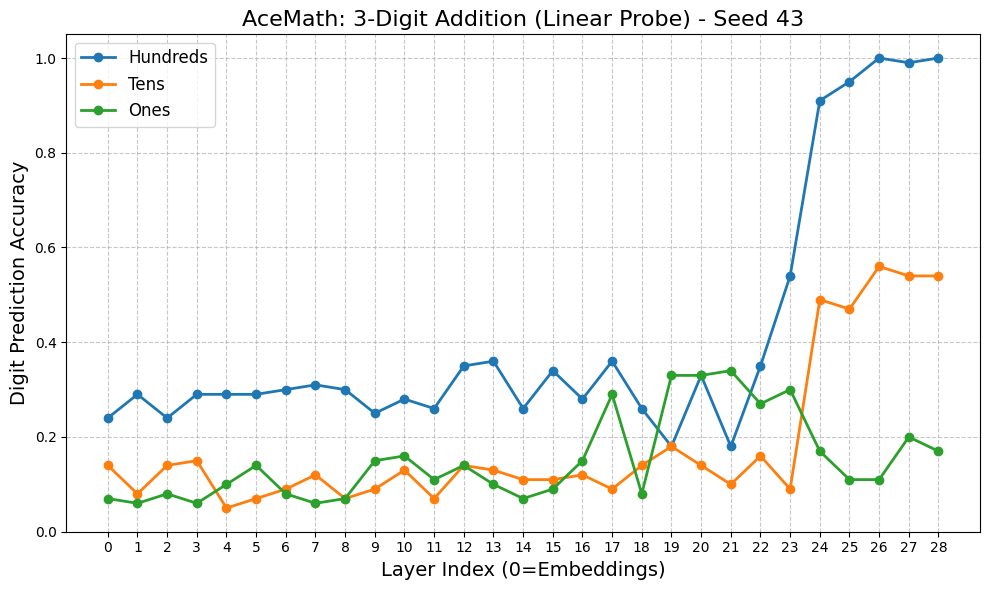

[Seed 44] Split: Train=800, Val=100, Test=100 / Total=1000
[Introspect] layers=28, hidden_size=3584


Caching-train:   0%|          | 0/7 [00:00<?, ?it/s]

Caching-val:   0%|          | 0/1 [00:00<?, ?it/s]

Caching-test:   0%|          | 0/1 [00:00<?, ?it/s]

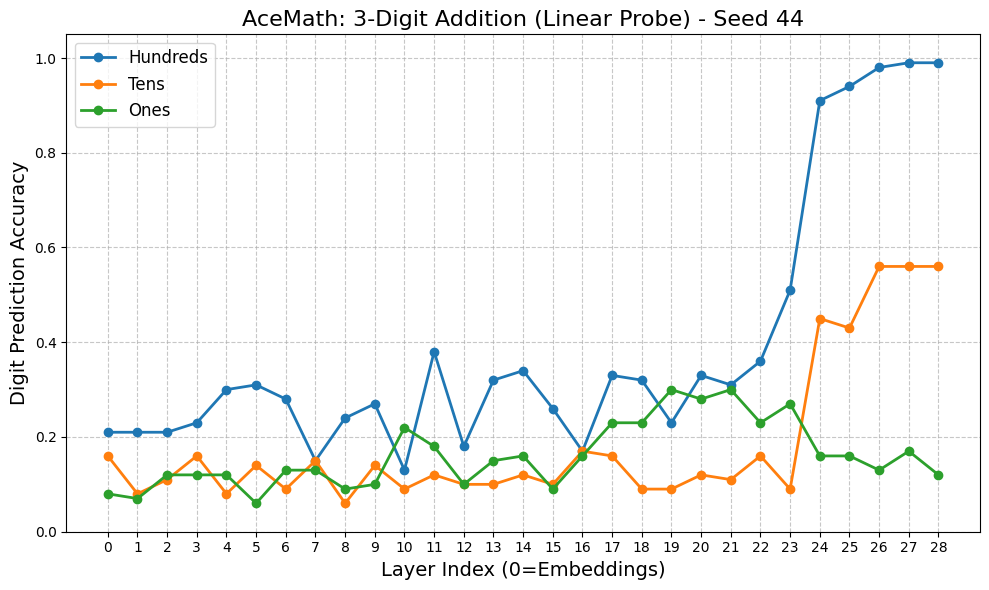

[Seed 45] Split: Train=800, Val=100, Test=100 / Total=1000
[Introspect] layers=28, hidden_size=3584


Caching-train:   0%|          | 0/7 [00:00<?, ?it/s]

Caching-val:   0%|          | 0/1 [00:00<?, ?it/s]

Caching-test:   0%|          | 0/1 [00:00<?, ?it/s]

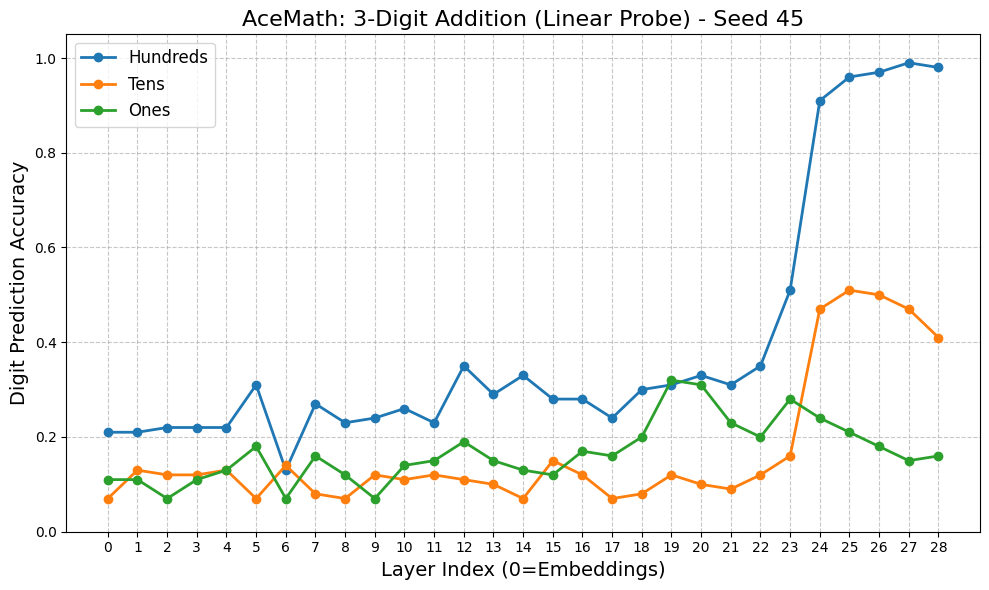

[Seed 46] Split: Train=800, Val=100, Test=100 / Total=1000
[Introspect] layers=28, hidden_size=3584


Caching-train:   0%|          | 0/7 [00:00<?, ?it/s]

Caching-val:   0%|          | 0/1 [00:00<?, ?it/s]

Caching-test:   0%|          | 0/1 [00:00<?, ?it/s]

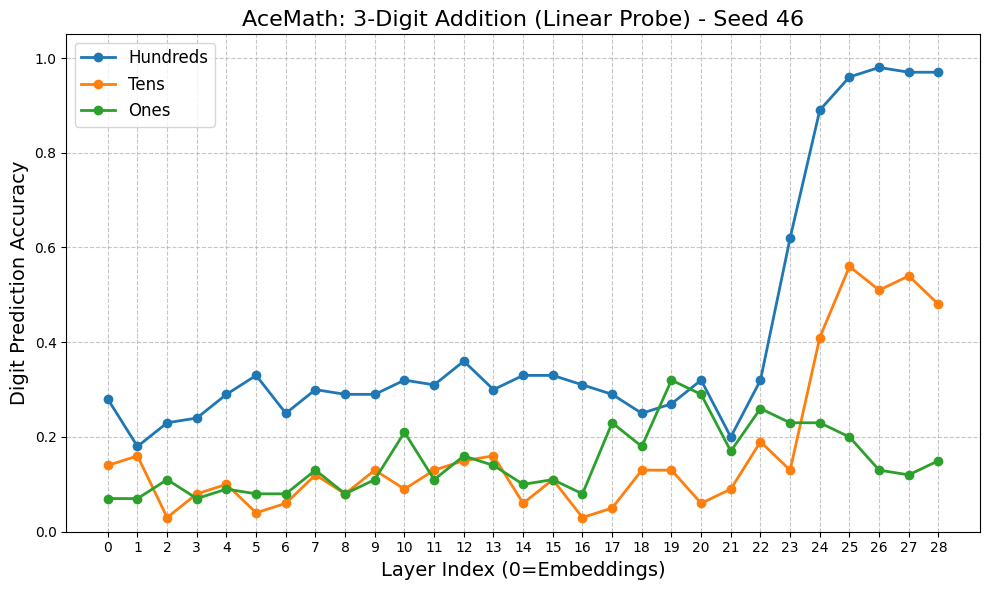

[Saved] AceMath/summary.csv


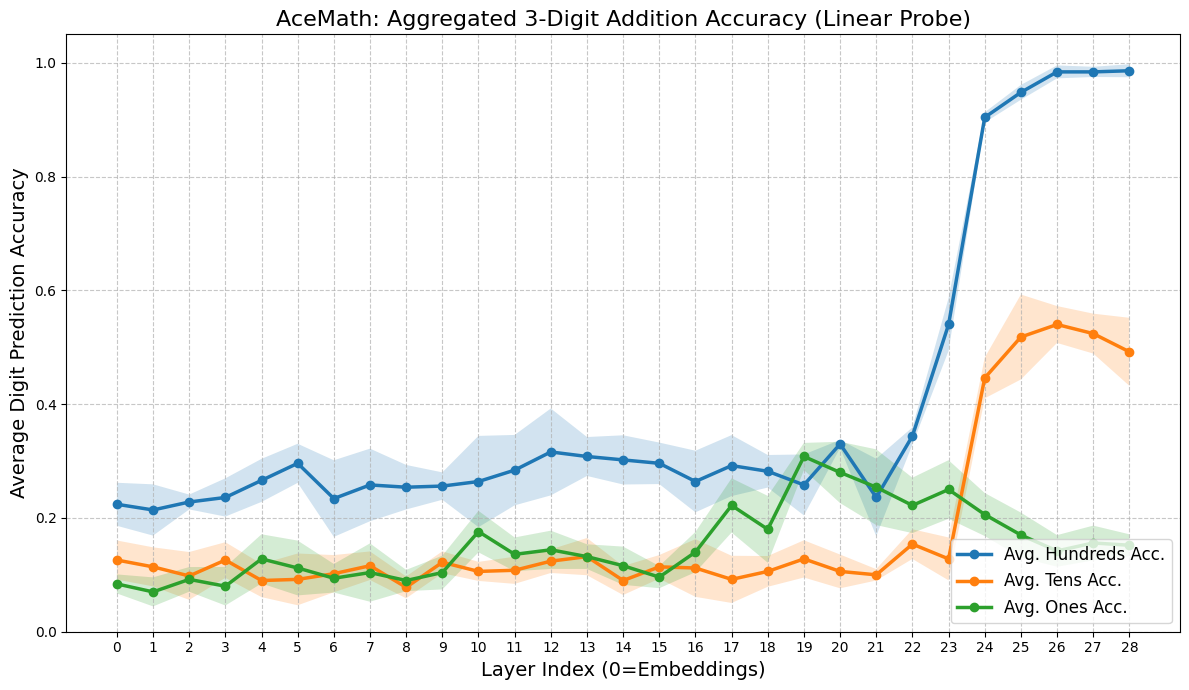

[Saved] Combined summary -> _combined_summary.csv


,seed,layer,hundreds,tens,ones,model,depth_norm
0,42,0,0.18,0.12,0.09,AceMath,0.000000
1,42,1,0.18,0.12,0.04,AceMath,0.035714
2,42,2,0.24,0.09,0.08,AceMath,0.071429
3,42,3,0.20,0.12,0.04,AceMath,0.107143
4,42,4,0.23,0.09,0.20,AceMath,0.142857


In [1]:
# -*- coding: utf-8 -*-
"""
Jupyter version: sequentially test multiple models listed in MODEL_NAMES
- Auto-detect number of layers via hidden_states
- Save each model's outputs under <output_root>/<model_name>/
- Generate a cross-model CSV (_combined_summary.csv) and comparison plots aligned by normalized depth
"""

# ===== Import light dependencies and define config first so CUDA_VISIBLE_DEVICES is set before importing torch =====
import os
from dataclasses import dataclass, field
from typing import List

@dataclass
class CFG:
    # Data & training
    n_digits: int = 3
    n_samples: int = 1000
    batch_size: int = 128
    probe_type: str = "linear"   # 'linear' | 'mlp'
    output_root: str = "./"
    epochs: int = 5
    lr: float = 1e-3
    patience: int = 3
    seeds: List[int] = field(default_factory=lambda: [42, 43, 44, 45, 46])

    # Device & precision
    cuda_visible_devices: str = "0"  # e.g., "0" | "1" | "0,1"
    force_device: str = "cuda:0"     # automatically falls back to CPU if CUDA is unavailable
    dtype: str = "auto"              # "auto" | "bfloat16" | "float16" | "float32"

    # Directory naming
    dir_name_mode: str = "basename"  # "basename" | "full_id"

    # Models to test in batch (HF repo id or local path)
    MODEL_NAMES: List[str] = field(default_factory=lambda: [
        #"/root/autodl-tmp/llama",
        #"/root/autodl-tmp/Mistral",
        #"/root/autodl-tmp/MetaMath",
        #"/root/autodl-tmp/Qwen2.5-Math-7B",
        "/root/autodl-tmp/AceMath"
    ])

cfg = CFG()

# Set visible GPUs before importing torch
os.environ["CUDA_VISIBLE_DEVICES"] = str(cfg.cuda_visible_devices)

# ===== Heavy dependencies & implementation logic =====
import re
import gc
import random
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM, AutoTokenizer


def get_model_device(model):
    try:
        return next(model.parameters()).device
    except StopIteration:
        return torch.device("cpu")


def safe_model_dir_name(model_id: str, mode: str = "basename") -> str:
    model_id = model_id.strip().rstrip("/")
    name = model_id.replace("/", "_") if mode == "full_id" else Path(model_id).name
    name = re.sub(r"[^A-Za-z0-9._\-]+", "_", name)
    name = re.sub(r"_+", "_", name).strip("_")
    return name or "model"


# ========== 1) Dataset ==========
class AdditionDataset(Dataset):
    """Generate n-digit addition samples where the sum is always a three-digit number (100..999)."""
    def __init__(self, n_digits: int, n_samples: int, tokenizer, *, seed: int):
        super().__init__()
        self.n_digits = n_digits
        self.n_samples = n_samples
        self.tok = tokenizer
        self.seed = seed
        self.samples: List[Dict] = []

        low_in = 10 ** (n_digits - 1)
        high_in = 10 ** n_digits - 1
        if max(low_in + low_in, 100) > min(high_in + high_in, 999):
            raise ValueError(f"n_digits={n_digits} yields sum range [{low_in*2},{high_in*2}], cannot guarantee it's always three digits.")
        self._generate()

    def _generate(self):
        low = 10 ** (self.n_digits - 1)
        high = 10 ** self.n_digits - 1
        rng = np.random.default_rng(seed=self.seed)
        max_attempts = max(self.n_samples * 100, 1000)
        attempts = 0
        while len(self.samples) < self.n_samples and attempts < max_attempts:
            attempts += 1
            a = int(rng.integers(low, high + 1))
            b = int(rng.integers(low, high + 1))
            res = a + b
            if 100 <= res <= 999:
                prompt = f"Calculate: {a}+{b} = "
                ids = self.tok.encode(prompt, add_special_tokens=False)
                digits = torch.tensor([int(ch) for ch in f"{res:03d}"], dtype=torch.long)
                self.samples.append({"input_ids": torch.tensor(ids), "answer_digits": digits})
        if len(self.samples) < self.n_samples:
            print(f"[Warn] Only generated {len(self.samples)}/{self.n_samples} valid samples.")

    def __len__(self): return len(self.samples)
    def __getitem__(self, idx): return self.samples[idx]


def make_collate(pad_id: int):
    def collate(batch):
        max_len = max(len(x["input_ids"]) for x in batch)
        input_ids = torch.full((len(batch), max_len), pad_id, dtype=torch.long)
        attention_mask = torch.zeros_like(input_ids)
        answer_digits = torch.stack([x["answer_digits"] for x in batch])
        for i, x in enumerate(batch):
            seq = x["input_ids"]
            input_ids[i, :len(seq)] = seq
            attention_mask[i, :len(seq)] = 1
        return {"input_ids": input_ids, "attention_mask": attention_mask, "answer_digits": answer_digits}
    return collate


# ========== 2) Probes ==========
class LinearProbe(nn.Module):
    def __init__(self, d_in: int):
        super().__init__()
        self.proj = nn.Linear(d_in, 10)
    def forward(self, x): return self.proj(x)


class MLPProbe(nn.Module):
    def __init__(self, d_in: int, hidden: int = 512):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(d_in, hidden), nn.ReLU(), nn.Linear(hidden, 10))
    def forward(self, x): return self.net(x)


# ========== 3) Training & evaluation ==========
@torch.no_grad()
def evaluate(model, X: torch.Tensor, y: torch.Tensor, *, batch_size: int = 4096) -> float:
    model.eval(); hits = total = 0
    for i in range(0, X.size(0), batch_size):
        out = model(X[i:i+batch_size])
        hits += (out.argmax(-1) == y[i:i+batch_size]).sum().item()
        total += y[i:i+batch_size].size(0)
    return hits/total if total>0 else 0.0


def train_probe(model, X, y, X_val, y_val, *, epochs=20, batch_size=4096, lr=1e-3, patience=3) -> float:
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss(); best_acc = wait = 0
    do_val = X_val.size(0) > 0
    for _ in range(epochs):
        model.train()
        perm = torch.randperm(X.size(0))
        for i in range(0, X.size(0), batch_size):
            idx = perm[i:i+batch_size]
            loss = ce(model(X[idx]), y[idx]); loss.backward(); opt.step(); opt.zero_grad()
        if do_val:
            acc = evaluate(model, X_val, y_val, batch_size=batch_size)
            if acc > best_acc + 1e-4:
                best_acc, wait = acc, 0
            else:
                wait += 1
            if wait >= patience: break
        else:
            best_acc = evaluate(model, X, y, batch_size=batch_size)
    return best_acc


# ========== 4) Single-seed pipeline (auto-detect #layers) ==========
def run_single_seed(args: CFG, *, seed: int, tok: AutoTokenizer, model, model_dir: Path, show_curves_in_notebook: bool = True) -> Tuple[np.ndarray, int]:
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

    # Data
    ds = AdditionDataset(args.n_digits, args.n_samples, tok, seed=seed)
    total = len(ds)
    n_train = int(0.8*total)
    n_val = int(0.1*total)
    if n_val == 0 and total > n_train: n_val = 1
    n_test = total - n_train - n_val
    if n_test == 0 and total > (n_train + n_val): n_test = 1
    if n_train + n_val + n_test != total:
        n_val = max(0, total - n_train - n_test)
    print(f"[Seed {seed}] Split: Train={n_train}, Val={n_val}, Test={n_test} / Total={total}")

    gen = torch.Generator().manual_seed(seed)
    train_set, val_set, test_set = torch.utils.data.random_split(ds, [n_train, n_val, n_test], generator=gen)
    collate = make_collate(tok.pad_token_id if tok.pad_token_id is not None else 0)
    dl_train = DataLoader(train_set, batch_size=args.batch_size, shuffle=False, collate_fn=collate)
    dl_val   = DataLoader(val_set,   batch_size=args.batch_size, shuffle=False, collate_fn=collate) if n_val>0 else None
    dl_test  = DataLoader(test_set,  batch_size=args.batch_size, shuffle=False, collate_fn=collate)

    # Run one forward pass to obtain hidden_states -> infer #layers and hidden size
    dev = get_model_device(model)
    model.eval()
    with torch.no_grad():
        first_batch = next(iter(dl_train if len(train_set)>0 else dl_test))
        out = model(
            input_ids=first_batch["input_ids"].to(dev),
            attention_mask=first_batch["attention_mask"].to(dev),
            use_cache=False,
            output_hidden_states=True
        )
        hidden_states = out.hidden_states
        num_layers = len(hidden_states) - 1
        d_model = hidden_states[-1].size(-1)
    print(f"[Introspect] layers={num_layers}, hidden_size={d_model}")

    # Cache activations (move to CPU)
    hidden = {split: [[] for _ in range(num_layers+1)] for split in ['train','val','test']}

    @torch.no_grad()
    def cache(split, loader):
        if loader is None: return
        for b in hidden[split]: b.clear()
        for batch in tqdm(loader, desc=f"Caching-{split}"):
            out = model(
                input_ids=batch['input_ids'].to(dev),
                attention_mask=batch['attention_mask'].to(dev),
                use_cache=False,
                output_hidden_states=True
            )
            hs = out.hidden_states
            B = hs[0].size(0)
            for b_idx in range(B):
                for lid in range(num_layers+1):
                    hidden[split][lid].append(hs[lid][b_idx].detach().cpu())

    cache('train', dl_train); cache('val', dl_val); cache('test', dl_test)

    # Assemble probe datasets and train/evaluate
    slots = ['hundreds','tens','ones']
    acc_matrix = np.zeros((num_layers+1, len(slots)))
    device_for_probe = dev if dev.type == 'cuda' else torch.device('cpu')

    def gather(buff_list, dataset_split):
        out={lid:{s:[] for s in slots} for lid in range(num_layers+1)}
        idx=0
        for sample in dataset_split:
            ln = len(sample['input_ids'])
            for lid in range(num_layers+1):
                h_last = buff_list[lid][idx][ln-1]  # representation of the last token
                for s_idx,s in enumerate(slots):
                    digit = sample['answer_digits'][s_idx].item()
                    out[lid][s].append((h_last, digit))
            idx+=1
        return out

    data = {
        'train': gather(hidden['train'], train_set),
        'val':   gather(hidden['val'], val_set) if len(val_set)>0 else {lid:{s:[] for s in slots} for lid in range(num_layers+1)},
        'test':  gather(hidden['test'], test_set)
    }

    ProbeCls = LinearProbe if args.probe_type=='linear' else MLPProbe
    for lid in range(num_layers+1):
        for s_idx,slot in enumerate(slots):
            train_items = data['train'][lid][slot]
            if not train_items: continue
            X_tr = torch.stack([h for h,_ in train_items]).to(device_for_probe).float()
            y_tr = torch.tensor([y for _,y in train_items]).to(device_for_probe)
            val_items = data['val'][lid][slot]
            if val_items:
                X_val = torch.stack([h for h,_ in val_items]).to(device_for_probe).float()
                y_val = torch.tensor([y for _,y in val_items]).to(device_for_probe)
            else:
                X_val = torch.empty(0,X_tr.size(1)).to(device_for_probe).float()
                y_val = torch.empty(0).to(device_for_probe).long()
            test_items = data['test'][lid][slot]
            if not test_items: continue
            X_te = torch.stack([h for h,_ in test_items]).to(device_for_probe).float()
            y_te = torch.tensor([y for _,y in test_items]).to(device_for_probe)

            probe = ProbeCls(d_model).to(device_for_probe)
            _ = train_probe(probe, X_tr, y_tr, X_val, y_val,
                            epochs=args.epochs, batch_size=args.batch_size, lr=args.lr, patience=args.patience)
            acc_matrix[lid,s_idx] = evaluate(probe, X_te, y_te, batch_size=args.batch_size)

    # Per-seed curve
    seed_dir = model_dir / f"seed{seed}"
    seed_dir.mkdir(parents=True, exist_ok=True)
    model_display = model_dir.name
    plt.figure(figsize=(10,6))
    for i,slot in enumerate(['hundreds','tens','ones']):
        plt.plot(np.arange(num_layers+1), acc_matrix[:,i],
                 linestyle='-', marker='o', markersize=6, linewidth=2, label=slot.capitalize())
    plt.xlabel("Layer Index (0=Embeddings)", fontsize=14)
    plt.ylabel("Digit Prediction Accuracy", fontsize=14)
    plt.title(f"{model_display}: {args.n_digits}-Digit Addition ({args.probe_type.capitalize()} Probe) - Seed {seed}", fontsize=16)
    plt.legend(fontsize=12); plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(np.arange(num_layers+1)); plt.ylim(0,1.05); plt.tight_layout()
    plt.savefig(seed_dir/"digit_probe_curve.png", dpi=300)
    plt.savefig(seed_dir/"digit_probe_curve.pdf")
    plt.show() if show_curves_in_notebook else plt.close()

    return acc_matrix, num_layers


# ========== 5) Aggregate across seeds ==========
def plot_aggregated_accuracies(summary_df: pd.DataFrame, output_dir: Path, args: CFG, num_layers: int, show_plot=True):
    slots=['hundreds','tens','ones']
    if summary_df.empty: return
    model_name = output_dir.name
    agg = summary_df.groupby('layer')[slots].agg(['mean','std']).reset_index()
    plt.figure(figsize=(12,7))
    for slot in slots:
        mean = agg[(slot,'mean')]
        std  = agg[(slot,'std')].fillna(0)
        layers = agg['layer']
        plt.plot(layers, mean, linestyle='-', marker='o', markersize=6, linewidth=2.5,
                 label=f"Avg. {slot.capitalize()} Acc.")
        plt.fill_between(layers, mean-std, mean+std, alpha=0.2)
    plt.xlabel("Layer Index (0=Embeddings)", fontsize=14)
    plt.ylabel("Average Digit Prediction Accuracy", fontsize=14)
    plt.title(f"{model_name}: Aggregated {args.n_digits}-Digit Addition Accuracy ({args.probe_type.capitalize()} Probe)", fontsize=16)
    plt.legend(fontsize=12, loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(np.arange(num_layers+1)); plt.ylim(0,1.05); plt.tight_layout()
    base = f"aggregated_{model_name}_{args.n_digits}digit_{args.probe_type}_accuracy"
    out = Path(output_dir); out.mkdir(parents=True, exist_ok=True)
    for ext in ['png','pdf','svg']:
        plt.savefig(out/f"{base}.{ext}", dpi=300)
    plt.show() if show_plot else plt.close()


# ========== 6) Single-model experiment entry ==========
def run_experiment(args: CFG, model_path: str, show_seed_curves=True, show_agg_curve=True):
    # Tokenizer
    tok = AutoTokenizer.from_pretrained(model_path)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token

    # dtype policy
    if args.dtype == "auto":
        if torch.cuda.is_available() and torch.cuda.is_bf16_supported():
            dtype = torch.bfloat16
        elif torch.cuda.is_available():
            dtype = torch.float16
        else:
            dtype = torch.float32
    else:
        dtype_map = {"bfloat16": torch.bfloat16, "float16": torch.float16, "float32": torch.float32}
        dtype = dtype_map[args.dtype]

    # Device
    target_device = args.force_device
    if not torch.cuda.is_available():
        print(f"[Info] CUDA unavailable, falling back to CPU. Visible devices: {os.environ.get('CUDA_VISIBLE_DEVICES', '(all/none)')}")
        target_device = "cpu"
        dtype = torch.float32

    # Load model
    model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype=dtype, device_map=None)
    model.to(target_device)
    print(f"[Placement] {safe_model_dir_name(model_path)} -> {target_device}, dtype={dtype}; CUDA_VISIBLE_DEVICES={os.environ.get('CUDA_VISIBLE_DEVICES', '(unset)')}")
    model.eval()

    # Output directory
    model_dir_name = safe_model_dir_name(model_path, mode=args.dir_name_mode)
    model_dir = Path(args.output_root) / model_dir_name
    model_dir.mkdir(parents=True, exist_ok=True)
    print(f"[Output] All files for this model will be saved to: {model_dir}")

    # Run per seed
    summary = []
    detected_layers = None
    for seed in args.seeds:
        mat, num_layers = run_single_seed(args, seed=seed, tok=tok, model=model, model_dir=model_dir, show_curves_in_notebook=show_seed_curves)
        detected_layers = num_layers
        for lid in range(mat.shape[0]):
            summary.append({'seed': seed, 'layer': lid,
                            'hundreds': mat[lid,0], 'tens': mat[lid,1], 'ones': mat[lid,2]})

    # Save CSV + aggregated plot
    df = pd.DataFrame(summary)
    if not df.empty:
        csv_path = model_dir/"summary.csv"
        df.to_csv(csv_path, index=False)
        print(f"[Saved] {csv_path}")
        plot_aggregated_accuracies(df, model_dir, args, detected_layers, show_plot=show_agg_curve)
    else:
        print("[Warn] Summary is empty, aggregated plot not generated.")

    # Cleanup
    try:
        del model, tok
    except Exception:
        pass
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    return df, model_dir, detected_layers


# ========== 7) Batch across multiple models ==========
def run_experiments_across_models(args: CFG, *, show_seed_curves=True, show_agg_curve=True):
    output_root = Path(args.output_root)
    output_root.mkdir(parents=True, exist_ok=True)

    all_rows = []
    for mp in args.MODEL_NAMES:
        print(f"\n====================\n[Run] {mp}\n====================")
        try:
            df, model_dir, n_layers = run_experiment(args, mp, show_seed_curves=show_seed_curves, show_agg_curve=show_agg_curve)
        except Exception as e:
            print(f"[Error] {mp}: {e}")
            continue
        if df is None or df.empty:
            print(f"[Warn] {mp}: summary is empty.")
            continue

        model_name = safe_model_dir_name(mp, mode=args.dir_name_mode)
        df["model"] = model_name
        # Align models of different depths using normalized depth (0=embeddings, 1=last)
        max_layer = df["layer"].max()
        df["depth_norm"] = (df["layer"] / max_layer) if max_layer > 0 else 0.0
        all_rows.append(df)

    if not all_rows:
        print("[Info] Nothing to summarize.")
        return pd.DataFrame()

    combined = pd.concat(all_rows, ignore_index=True)
    combined_csv = output_root / "_combined_summary.csv"
    combined.to_csv(combined_csv, index=False)
    print(f"[Saved] Combined summary -> {combined_csv}")

    # Cross-model comparison plots (by normalized depth)
    def plot_cross_model(slot: str):
        plt.figure(figsize=(12, 7))
        for model_name, group in combined.groupby("model"):
            bins = np.linspace(0, 1, 13)  # 12 bins smoothing
            inds = np.digitize(group["depth_norm"], bins) - 1
            xs, ys = [], []
            for k in range(12):
                vals = group.loc[inds == k, slot]
                if not vals.empty:
                    xs.append((bins[k] + bins[k+1]) / 2)
                    ys.append(vals.mean())
            if xs:
                plt.plot(xs, ys, marker='o', linewidth=2, label=model_name)
        plt.xlabel("Normalized layer depth (0 = Embeddings, 1 = Last Layer)", fontsize=14)
        plt.ylabel(f"{slot.capitalize()} Digit Accuracy", fontsize=14)
        plt.title(f"Cross-Model {slot.capitalize()} Accuracy vs Depth (Normalized)", fontsize=16)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=10)
        base = output_root / f"cross_model_{slot}_accuracy_vs_depth"
        for ext in ['png','pdf','svg']:
            plt.savefig(f"{base}.{ext}", dpi=300)
        plt.close()

    for slot in ['hundreds', 'tens', 'ones']:
        plot_cross_model(slot)

    return combined


# ======================
# Run (edit cfg.MODEL_NAMES as needed)
# ======================

# A) Batch run multiple models (recommended)
combined = run_experiments_across_models(cfg, show_seed_curves=True, show_agg_curve=True)
try:
    from IPython.display import display
    display(combined.head())
except Exception:
    print(combined.head())
